# Projects in AI and ML HW4 Task 2

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset I am using is an Air Quality dataset from kaggle: https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set/data.

The problem to solve for this dataset is to predict future air pollution levels based on historical sensor readings. Sequence models should be used for this because it is measuring air pollution. Air pollution is influenced by a lot of time-dependent factors including weather conditions and seasonal changes. Pollutant levels depend on prior readings, so sequence models like RNN is needed to be able to learn temporal dependencies. Other more basic machine learning models like regression or decision trees would not be able to effectively identify sequential patterns and would not really be able to accurately predict levels based on temporal factors. Therefore, sequence models are needed to solve this problem.   

For this RNN implementation, I will used TensorFlow, specifically using the keras resource to solve this problem.

In [20]:
data_path = "/content/drive/My Drive/Projects in AI and ML/hw4/AirQuality.csv"
df = pd.read_csv(data_path)
data = pd.read_csv(data_path,sep=';')

data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


#Perform some EDA

In [23]:
data.drop(['Unnamed: 15','Unnamed: 16'],axis=1,inplace=True)

In [24]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [26]:
data.iloc[:,2] = data.iloc[:,2].replace(',','.',regex=True)
data.iloc[:,5] = data.iloc[:,5].replace(',','.',regex=True)
data.iloc[:,12] = data.iloc[:,12].replace(',','.',regex=True)
data.iloc[:,13] = data.iloc[:,13].replace(',','.',regex=True)
data.iloc[:,14] = data.iloc[:,14].replace(',','.',regex=True)

In [27]:
data.drop(['Date','Time'],axis=1,inplace=True)
data = data.astype({'CO(GT)':'float64',
             'C6H6(GT)':'float64',
             'T':'float64',
             'RH':'float64',
             'AH':'float64'})

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 962.0 KB


In [29]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [30]:
data.isnull().sum()

,0
CO(GT),114
PT08.S1(CO),114
NMHC(GT),114
C6H6(GT),114
PT08.S2(NMHC),114
NOx(GT),114
PT08.S3(NOx),114
NO2(GT),114
PT08.S4(NO2),114
PT08.S5(O3),114


In [31]:
# delete rows with nulls
data.dropna(inplace=True)

In [32]:
data.duplicated().sum()

31

In [33]:
data.drop_duplicates(inplace=True,ignore_index=True)

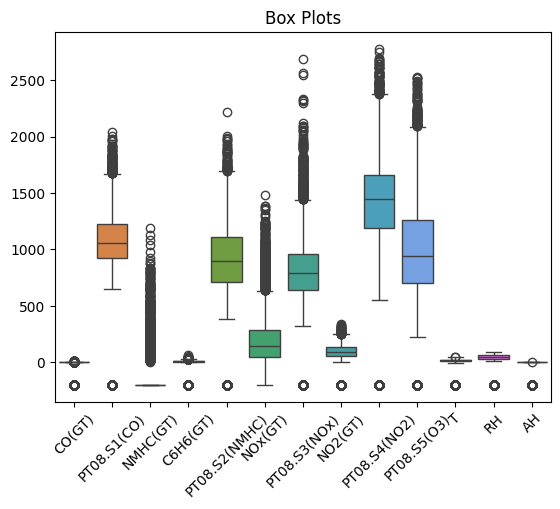

In [36]:
sns.boxplot(data)
plt.xticks(rotation=45)
plt.title('Box Plots');

In [38]:
df = data.reset_index().drop('index',axis=1)

In [39]:
X = df.copy()

In [40]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

X = pd.DataFrame(pt.fit_transform(X),columns=X.columns)

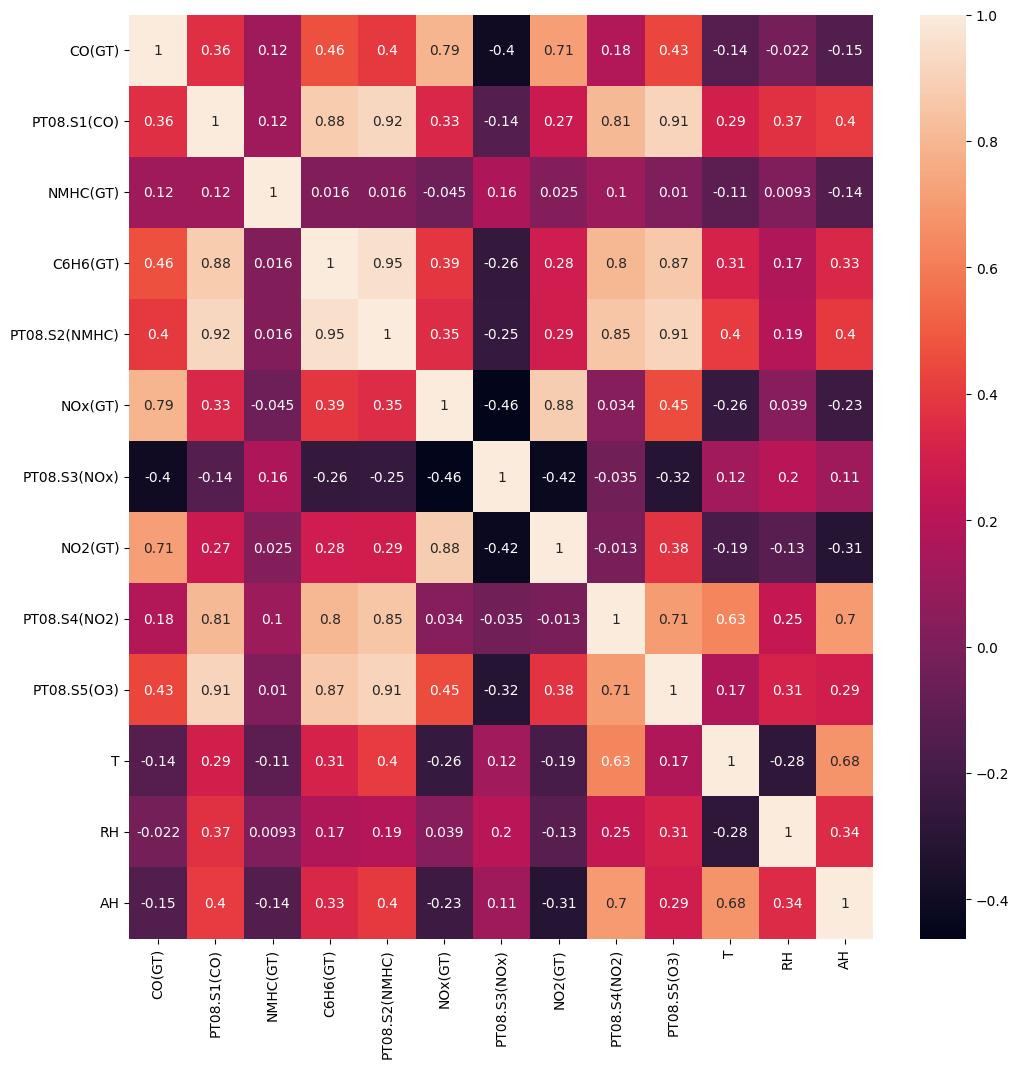

In [41]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),annot=True)
plt.show()

In [42]:
y = X['C6H6(GT)']
X = X.drop('C6H6(GT)',axis=1)

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=6,shuffle=True)

I am using tanh and linear activation functions in the following RNN model.

In [67]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))) # RNN cell with tanh activation
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1, activation='linear')) # Output layer with linear activation

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Train MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Inverse transform the data
y_train_inv = pt.inverse_transform(np.concatenate([X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train.values.reshape(-1,1)],axis=1))[:,-1]
y_test_inv = pt.inverse_transform(np.concatenate([X_test.reshape(X_test.shape[0], X_test.shape[2]), y_test.values.reshape(-1,1)],axis=1))[:,-1]

y_pred_train_inv = pt.inverse_transform(np.concatenate([X_train.reshape(X_train.shape[0], X_train.shape[2]), y_pred_train.reshape(-1,1)],axis=1))[:,-1]
y_pred_test_inv = pt.inverse_transform(np.concatenate([X_test.reshape(X_test.shape[0], X_test.shape[2]), y_pred_test.reshape(-1,1)],axis=1))[:,-1]

# Calculate R-squared
r2_train = r2_score(y_train_inv, y_pred_train_inv)
r2_test = r2_score(y_test_inv, y_pred_test_inv)

print(f"Train R-squared: {r2_train}")
print(f"Test R-squared: {r2_test}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4686 - mae: 0.4287 - val_loss: 0.0651 - val_mae: 0.1407
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0568 - mae: 0.1439 - val_loss: 0.0309 - val_mae: 0.1022
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0595 - mae: 0.1201 - val_loss: 0.0192 - val_mae: 0.0758
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0245 - mae: 0.0958 - val_loss: 0.0119 - val_mae: 0.0588
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - mae: 0.0857 - val_loss: 0.0084 - val_mae: 0.0472
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mae: 0.0780 - val_loss: 0.0069 - val_mae: 0.0406
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - mae: 0.0730 - val_loss: 0.0049 - val_mae: 0.0339
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - mae: 0.0738 - val_loss: 0.0044 - val_mae: 0.0348
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


This model performs fairly well with an r-squared value close to 1 and a small MAE.

## Update the network with a GRU based structure.

In [68]:
# LSTM Model already implemented in the previous step

# GRU Model
model_gru = Sequential()
model_gru.add(GRU(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='linear'))

model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_gru], verbose=1)

train_loss_gru, train_mae_gru = model_gru.evaluate(X_train, y_train, verbose=0)
test_loss_gru, test_mae_gru = model_gru.evaluate(X_test, y_test, verbose=0)
print(f'GRU - Train MAE: {train_mae_gru:.4f}')
print(f'GRU - Test MAE: {test_mae_gru:.4f}')

y_pred_train_gru = model_gru.predict(X_train)
y_pred_test_gru = model_gru.predict(X_test)

y_pred_train_inv_gru = pt.inverse_transform(np.concatenate([X_train.reshape(X_train.shape[0], X_train.shape[2]), y_pred_train_gru.reshape(-1,1)],axis=1))[:,-1]
y_pred_test_inv_gru = pt.inverse_transform(np.concatenate([X_test.reshape(X_test.shape[0], X_test.shape[2]), y_pred_test_gru.reshape(-1,1)],axis=1))[:,-1]

r2_train_gru = r2_score(y_train_inv, y_pred_train_inv_gru)
r2_test_gru = r2_score(y_test_inv, y_pred_test_inv_gru)

print(f"GRU - Train R-squared: {r2_train_gru}")
print(f"GRU - Test R-squared: {r2_test_gru}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4590 - mae: 0.4174 - val_loss: 0.0631 - val_mae: 0.1535
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0925 - mae: 0.1755 - val_loss: 0.0355 - val_mae: 0.1170
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - mae: 0.1427 - val_loss: 0.0224 - val_mae: 0.0880
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0307 - mae: 0.1135 - val_loss: 0.0157 - val_mae: 0.0662
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0266 - mae: 0.1014 - val_loss: 0.0109 - val_mae: 0.0546
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214 - mae: 0.0890 - val_loss: 0.0086 - val_mae: 0.0479
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - mae: 0.0875 - val_loss: 0.0079 - val_mae: 0.0468
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mae: 0.0808 - val_loss: 0.0068 - val_mae: 0.0429
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


The GRU model also performs fairly well with r-squared values close to 1 and a small MAE.

In [69]:
# Compare the two models
print("\nPerformance Comparison:")
print("----------------------")
print(f"\nLSTM:")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {r2_test}")

print(f"\nGRU:")
print(f"Test MAE: {test_mae_gru}")
print(f"Test R^2: {r2_test_gru}")



Performance Comparison:
----------------------

LSTM:
Test MAE: 0.028410863131284714
Test R^2: 0.9356334177793516

GRU:
Test MAE: 0.01723191887140274
Test R^2: 0.9859629959314368


From above, we can see that the GRU structure performed better.   

The main difference between the LSTM and GRU implementations is with their internal architecture and how they regulate information flow. LSTMs have input, forget and output gates while GRU only have update and reset and combine the cell state and hidden state. GRUs are therefore computationally less expensive than LSTMs, which leads to faster training. Both of these models address the vanishing gradient problem that arises with basic RNNs. Overall, GRUs are more efficient than LSTMs and still have comparable performance, especially as seen in my example above.

You could possibly use a traditional feed-forward network to solve the same problem, but it would not be ideal as it would not be able to capture the temporal dependencies or sequences in the data. You could convert time series to features. For example, you could create new features representing past values or you could compute rolling statistics over a window of data. However, in general, a feed-forward network treats each input as independent from one another and does not have hte memory of past inputs, so it is not able to learn the order or the relationships of the data over time. This results in a major loss of information about sequential patterns, making the result much less accurate. For time series, the relationship over time between data points is important, so a simple feed-forward network would not be effectively able to solve the same problem.